## Peptides-Modifications Matching Problem

### Load data to a pandas dataframe

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from networkx.algorithms import bipartite
import networkx as nx

%matplotlib inline

df = pd.read_csv('datasets/data', delimiter = "\t")
df

,spectrum_key,peptide_key,peptide_sequence,n_mods,p_score,d_score,modification_mass,modification_site
0,-3890386021042264016,-971972119423103052,RLAVTGPRYRHPKKVGGTSPASKRTAKTALQKRPAKGGTSKRATQKTLA,42.0105646837:3_42.04695019242:1,12.5,0.0,42.04695,13
1,-3890386021042264016,-971972119423103052,RLAVTGPRYRHPKKVGGTSPASKRTAKTALQKRPAKGGTSKRATQKTLA,42.0105646837:3_42.04695019242:1,12.5,0.0,42.04695,14
2,-3890386021042264016,-971972119423103052,RLAVTGPRYRHPKKVGGTSPASKRTAKTALQKRPAKGGTSKRATQKTLA,42.0105646837:3_42.04695019242:1,12.5,0.0,42.04695,23
3,-3890386021042264016,-971972119423103052,RLAVTGPRYRHPKKVGGTSPASKRTAKTALQKRPAKGGTSKRATQKTLA,42.0105646837:3_42.04695019242:1,12.5,0.0,42.04695,27
4,-3890386021042264016,-971972119423103052,RLAVTGPRYRHPKKVGGTSPASKRTAKTALQKRPAKGGTSKRATQKTLA,42.0105646837:3_42.04695019242:1,12.5,0.0,42.04695,32
...,...,...,...,...,...,...,...,...
3078,5591073127866348215,-8881249935239163276,RLAVTGPRYRHPKKVGGTSPASKRTAKTALQKRPAKGGTSKRATQKTLA,42.0105646837:2_42.04695019242:2,25.0,0.0,42.04695,27
3079,5591073127866348215,-8881249935239163276,RLAVTGPRYRHPKKVGGTSPASKRTAKTALQKRPAKGGTSKRATQKTLA,42.0105646837:2_42.04695019242:2,25.0,0.0,42.04695,32
3080,5591073127866348215,-8881249935239163276,RLAVTGPRYRHPKKVGGTSPASKRTAKTALQKRPAKGGTSKRATQKTLA,42.0105646837:2_42.04695019242:2,25.0,0.0,42.04695,36
3081,5591073127866348215,-8881249935239163276,RLAVTGPRYRHPKKVGGTSPASKRTAKTALQKRPAKGGTSKRATQKTLA,42.0105646837:2_42.04695019242:2,25.0,0.0,42.04695,41


#### Find matching of peptide-modifications graph

In [16]:
def find_subgraph_matching(df, sample):
    sample = df.loc[(df['spectrum_key'] == sample['spectrum_key']) & (df['peptide_key'] == sample['peptide_key'])]
    n = len(sample['modification_site'].unique().tolist())
    modifications_num_dict = {float(x.split(':')[0]) : int(x.split(':')[1]) for x in sample['n_mods'].iloc[1].split('_')}
    k = sum(modifications_num_dict.values())
    A = sample['modification_site'].unique().tolist()
    D = [key for key in modifications_num_dict for i in range(modifications_num_dict[key])]
    V = A + D
    keys = [key for key in modifications_num_dict]
    V_names = ['site '+str(i) for i in A] + ['mod '+str(i)+' occ '+str(j) for i in range(len(keys)) for j in     range(modifications_num_dict[keys[i]])]
    E = []
    for index, row in sample.iterrows():
        net_edges = [(V_names[A.index(row['modification_site'])], V_names[len(A)+i], row['p_score']) for i in         np.where(np.array(D)==row['modification_mass'])[0].tolist()]
        E = E + net_edges

    G = nx.Graph()
    # Add nodes with the node attribute "bipartite"
    G.add_nodes_from(V_names[:len(A)], bipartite=0)
    G.add_nodes_from(V_names[len(A):], bipartite=1)
    G.add_weighted_edges_from(E)
    
    matching = nx.algorithms.max_weight_matching(G)
    matching_weights_sum = 0.0
    matching_edges = []
    for m in matching:
        match_info = [sample['spectrum_key'].iloc[0], sample['peptide_key'].iloc[0]]
        for e in E:
            if m[0] in str(e) and m[1] in str(e):
                matching_weights_sum += e[2]
                if 'site' in m[0]:
                    match_info.append(int(m[0].split(' ')[1]))
                    match_info.append(D[V_names.index(m[1])-len(A)])
                else:
                    match_info.append(int(m[1].split(' ')[1]))
                    match_info.append(D[V_names.index(m[0])-len(A)])
        matching_edges.append(match_info)
    return matching_edges, len(V), len(E)

#### Get all different pairs of spectrum_key peptide_key values

In [17]:
samples = df[['spectrum_key','peptide_key']].drop_duplicates()
matchings_info = []
graph_statistics = []
for index, sample in samples.iterrows():
    matching, num_V, num_E = find_subgraph_matching(df, sample)
    for e in matching:
        matchings_info.append(e)
    graph_statistics.append([sample['spectrum_key'], sample['peptide_key'], num_V, num_E])
print(matchings_info[0])
print('Number of nodes:', graph_statistics[0][2])
print('Number of edges:', graph_statistics[0][3])

[-3890386021042264016, -971972119423103052, 13, 42.04695019242]
Number of nodes: 13
Number of edges: 35


### Violin plots of graph sizes

In [18]:
plotted_num_nodes = np.array(graph_statistics)[:,2].tolist()
plotted_num_edges = np.array(graph_statistics)[:,3].tolist()

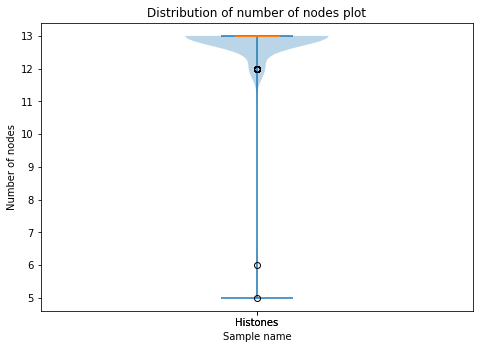

In [19]:
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

labels = ['Histones']
set_axis_style(ax, labels)

bp = ax.violinplot(plotted_num_nodes)

bplot1 = ax.boxplot(plotted_num_nodes,
                     vert=True,  # vertical box alignment
                     patch_artist=False,  # fill with color
                     labels=labels)  # will be used to label x-ticks

ax.set_title('Distribution of number of nodes plot')
ax.set_ylabel('Number of nodes')


plt.show()

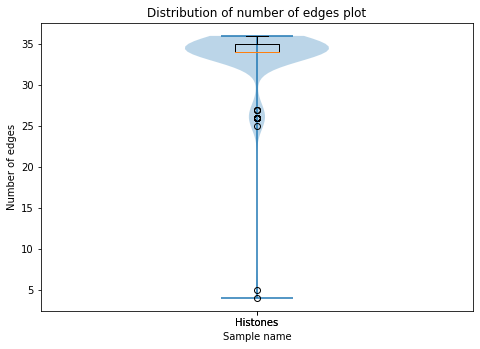

In [20]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

labels = ['Histones']
set_axis_style(ax, labels)

bp = ax.violinplot(plotted_num_edges)

bplot1 = ax.boxplot(plotted_num_edges,
                     vert=True,  # vertical box alignment
                     patch_artist=False,  # fill with color
                     labels=labels)  # will be used to label x-ticks

ax.set_title('Distribution of number of edges plot')
ax.set_ylabel('Number of edges')

plt.show()

#### Store graph statistics in a tab delimeted csv file

In [21]:
data = [graph_statistics[i] for i in range(len(graph_statistics))]
stats_df = pd.DataFrame(data, columns = ['spectrum_key', 'peptide_key', 'number_of_nodes', 'number_of_edges'])
stats_df.to_csv('graph_size_open_search.csv', index=False, sep ='\t')